In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import shap
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, make_scorer, roc_auc_score, recall_score
from sklearn.model_selection import ParameterGrid, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('processed_data.csv')

In [3]:
def prepare_datasets(df):
    # Supprimer la colonne 'SK_ID_CURR'
    df = df.drop(columns=['SK_ID_CURR']).copy()

    # Séparer df en df_train et df_test en utilisant la colonne 'TARGET'
    train_df = df[df['TARGET'].notna()].copy()
    test_df = df[df['TARGET'].isna()].copy()

    # Supprimer la colonne 'TARGET' de df_test puisque ce n'est pas nécessaire pour les données de test
    test_df = test_df.drop(columns=['TARGET']).copy()

    # Traiter les valeurs manquantes en les remplaçant par la médiane pour les colonnes numériques
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Remplacer les valeurs manquantes pour les colonnes numériques par la médiane
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())
    
    # Remplacer les valeurs manquantes pour les colonnes catégoriques par le mode
    categorical_cols = train_df.select_dtypes(include=['category', 'object']).columns
    for col in categorical_cols:
        train_df[col] = train_df[col].copy()  # Crée une copie avant la modification
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

    # Fonction pour nettoyer les noms de colonnes
    def clean_column_names(columns):
        return [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in columns]

    # Renommer les colonnes pour supprimer les caractères spéciaux
    train_df.columns = clean_column_names(train_df.columns)
    test_df.columns = clean_column_names(test_df.columns)

    # Séparer les features et les labels
    X = train_df.drop(columns=['TARGET'])
    y = train_df['TARGET']

    # Vérifier les formes des dataframes
    print(f"train_df shape: {train_df.shape}")
    print(f"test_df shape: {test_df.shape}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    return X, y, test_df

In [4]:
# Appel de la fonction avec le DataFrame 'df'
X, y, test_df = prepare_datasets(df)

train_df shape: (307511, 809)
test_df shape: (48744, 808)
X shape: (307511, 808)
y shape: (307511,)


Cette fonction calcule un coût pondéré pour les faux négatifs et faux positifs, utilisé pour optimiser le modèle en minimisant les erreurs les plus coûteuses.

In [5]:
def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (cost_fn * fn) + (cost_fp * fp)
    return -cost  # Le coût est négatif car on veut minimiser ce score

# Créer le business_scorer pour GridSearchCV
business_scorer = make_scorer(custom_cost_function, greater_is_better=False)

Cette fonction évalue un modèle en utilisant deux stratégies possibles de gestion des données déséquilibrées (sous-échantillonnage ou aucune action), tout en appliquant un pipeline complet de prétraitement (imputation des NaN, conversion des données et normalisation). Le modèle est optimisé à l'aide de GridSearchCV en testant diverses combinaisons d'hyperparamètres, avec un focus particulier sur la minimisation du coût métier, et enregistre les résultats détaillés de chaque combinaison testée.

In [6]:
def evaluate_model(model, model_name, unbalanced_strat, param_grid, X, y):
    # Construire dynamiquement le pipeline en fonction de la stratégie choisie
    if unbalanced_strat == 'Undersampling':
        unbalanced = RandomUnderSampler(random_state=42)
    else:
        unbalanced = 'passthrough'
    
    # Construire le pipeline avec gestion du déséquilibre, traitement des NaN, et conversion en numérique
    pipeline = Pipeline(steps=[
    ('unbalanced', unbalanced),
    ('imputer', SimpleImputer(strategy='median')),
    ('numeric_conversion', FunctionTransformer(lambda x: x.astype(np.float64))),
    ('scaler', StandardScaler()), 
    ('model', model)
])
    
    # Afficher le nombre de combinaisons de paramètres
    print(f"Model: {model_name}, Number of parameter combinations: {len(list(ParameterGrid(param_grid)))}")

    scoring = {
        'business_score': business_scorer,
        'roc_auc': 'roc_auc',
        'f1': make_scorer(f1_score, zero_division=1),
        'precision': make_scorer(precision_score, zero_division=1),
        'recall': 'recall',
        'log_loss': 'neg_log_loss'
    }

    # Chronométrage
    start_time = time.time()

    # Configurer GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, 
                               scoring=scoring, refit='business_score', 
                               return_train_score=True, error_score='raise', n_jobs=1)

    # Entraîner le modèle
    grid_search.fit(X, y)

    # Calcul du temps d'exécution
    elapsed_time = time.time() - start_time

    print(f"Finished model: {model_name} with strategy: {unbalanced_strat} in {elapsed_time / 60:.2f} minutes")

    # Initialiser une liste pour stocker toutes les combinaisons
    all_results = []

    # Boucle pour enregistrer toutes les combinaisons
    for i in range(len(grid_search.cv_results_['params'])):
        all_results.append({
            'model_name': model_name,
            'unbalanced_strat': unbalanced_strat,
            'business_score': grid_search.cv_results_['mean_test_business_score'][i], 
            'auc': grid_search.cv_results_['mean_test_roc_auc'][i],
            'f1': grid_search.cv_results_['mean_test_f1'][i],
            'precision': grid_search.cv_results_['mean_test_precision'][i],
            'recall': grid_search.cv_results_['mean_test_recall'][i],
            'log_loss': grid_search.cv_results_['mean_test_log_loss'][i],
            'fit_time': grid_search.cv_results_['mean_fit_time'][i],
            'execution_time': elapsed_time,
            'best_params': grid_search.cv_results_['params'][i],
            'best_model': grid_search.best_estimator_
        })

    # Retourner toutes les combinaisons
    return grid_search, all_results

Cette section définit une liste de modèles de classification avec leurs hyperparamètres associés, prêts à être testés et optimisés dans le cadre de l'évaluation du modèle.

In [7]:
models = {
    "Dummy": DummyClassifier(strategy='stratified', random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(force_col_wise=True, random_state=42, verbose=-1)
}

param_grid = {
    "Dummy": {},
    "Logistic Regression": {'model__C': [0.1, 1], 'model__max_iter': [500]},
    "Random Forest": {'model__n_estimators': [100, 200], 'model__max_depth': [10]},
    "Gradient Boosting": {'model__n_estimators': [100, 200], 'model__learning_rate': [0.1]},
    "XGBoost": {'model__n_estimators': [50, 100], 'model__max_depth': [3]},
    "LightGBM": {
        'model__learning_rate': [0.01, 0.03],
        'model__n_estimators': [500, 1200],
        'model__max_depth': [5],
        'model__num_leaves': [31],
        'model__min_child_samples': [175],
        'model__feature_fraction': [0.8],
        'model__bagging_fraction': [0.8],
        'model__bagging_freq': [3],
    }
}

Cette fonction exécute une recherche en grille complète pour plusieurs modèles et stratégies de gestion des données déséquilibrées, en utilisant la fonction `evaluate_model`. Elle collecte et compile tous les résultats dans un DataFrame, trié par le score de coût métier pour identifier les meilleures configurations.

In [8]:
def run_full_grid_search(models, param_grid, X, y):
    # Initialiser une liste pour stocker tous les résultats
    all_results = []

    # Boucle sur chaque modèle
    for model_name, model in models.items():
        print(f"Running grid search for model: {model_name}")
        
        # Boucle sur chaque stratégie ('Undersampling', 'None')
        for strat in ['Undersampling', 'None']:
            print(f"Testing strategy: {strat}")
            
            # Appel à evaluate_model pour effectuer le grid_search avec la stratégie actuelle
            grid_search, results = evaluate_model(model, model_name, strat, param_grid[model_name], X, y)
            
            # Ajouter les résultats pour chaque stratégie et modèle
            all_results.extend(results)
    
    # Convertir les résultats en DataFrame pour une visualisation plus facile
    results_df = pd.DataFrame(all_results)

    # Trier les résultats par le business_score (le plus bas est meilleur)
    sorted_results_df = results_df.sort_values(by='business_score', ascending=True)
    
    # Retourner le DataFrame trié avec tous les résultats
    return sorted_results_df

In [9]:
# Exécuter le grid_search sur l'ensemble des données
final_results_df = run_full_grid_search(models, param_grid, X, y)

Running grid search for model: Dummy
Testing strategy: Undersampling
Model: Dummy, Number of parameter combinations: 1
Finished model: Dummy with strategy: Undersampling in 2.53 minutes
Testing strategy: None
Model: Dummy, Number of parameter combinations: 1
Finished model: Dummy with strategy: None in 5.67 minutes
Running grid search for model: Logistic Regression
Testing strategy: Undersampling
Model: Logistic Regression, Number of parameter combinations: 2
Finished model: Logistic Regression with strategy: Undersampling in 6.06 minutes
Testing strategy: None
Model: Logistic Regression, Number of parameter combinations: 2
Finished model: Logistic Regression with strategy: None in 13.89 minutes
Running grid search for model: Random Forest
Testing strategy: Undersampling
Model: Random Forest, Number of parameter combinations: 2
Finished model: Random Forest with strategy: Undersampling in 9.60 minutes
Testing strategy: None
Model: Random Forest, Number of parameter combinations: 2
Fini

In [10]:
# Afficher le DataFrame complet des résultats
final_results_df

,model_name,unbalanced_strat,business_score,auc,f1,precision,recall,log_loss,fit_time,execution_time,best_params,best_model
21,LightGBM,Undersampling,30235.0,0.785448,0.289237,0.181453,0.712467,-0.558710,13.499774,620.685799,"{'model__bagging_fraction': 0.8, 'model__baggi...","(RandomUnderSampler(random_state=42), SimpleIm..."
20,LightGBM,Undersampling,30491.2,0.782564,0.286769,0.179661,0.710171,-0.561177,10.116508,620.685799,"{'model__bagging_fraction': 0.8, 'model__baggi...","(RandomUnderSampler(random_state=42), SimpleIm..."
19,LightGBM,Undersampling,30628.8,0.781690,0.285490,0.178748,0.708761,-0.562128,14.652628,620.685799,"{'model__bagging_fraction': 0.8, 'model__baggi...","(RandomUnderSampler(random_state=42), SimpleIm..."
15,XGBoost,Undersampling,30952.8,0.776503,0.282868,0.177001,0.703927,-0.566473,7.516612,240.025100,"{'model__max_depth': 3, 'model__n_estimators':...","(RandomUnderSampler(random_state=42), SimpleIm..."
11,Gradient Boosting,Undersampling,31004.4,0.777862,0.282206,0.176463,0.704209,-0.565605,327.429265,3005.777161,"{'model__learning_rate': 0.1, 'model__n_estima...","(RandomUnderSampler(random_state=42), SimpleIm..."
14,XGBoost,Undersampling,31274.6,0.772644,0.279877,0.174853,0.700866,-0.570330,7.191022,240.025100,"{'model__max_depth': 3, 'model__n_estimators':...","(RandomUnderSampler(random_state=42), SimpleIm..."
18,LightGBM,Undersampling,31464.6,0.771891,0.277562,0.172995,0.701752,-0.573728,10.937748,620.685799,"{'model__bagging_fraction': 0.8, 'model__baggi...","(RandomUnderSampler(random_state=42), SimpleIm..."
10,Gradient Boosting,Undersampling,31587.8,0.770762,0.276727,0.172500,0.699215,-0.573422,167.039728,3005.777161,"{'model__learning_rate': 0.1, 'model__n_estima...","(RandomUnderSampler(random_state=42), SimpleIm..."
2,Logistic Regression,Undersampling,31725.0,0.768988,0.275469,0.171596,0.698046,-0.579806,8.877811,363.718601,"{'model__C': 0.1, 'model__max_iter': 500}","(RandomUnderSampler(random_state=42), SimpleIm..."
3,Logistic Regression,Undersampling,31757.6,0.768731,0.275129,0.171338,0.697966,-0.581410,10.437672,363.718601,"{'model__C': 1, 'model__max_iter': 500}","(RandomUnderSampler(random_state=42), SimpleIm..."


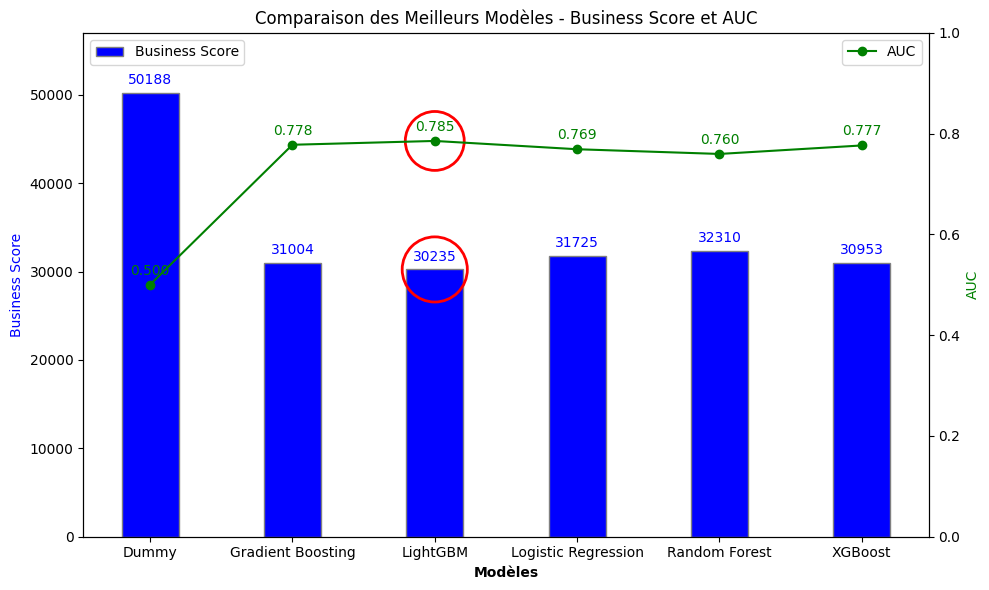

In [62]:
# Garder uniquement les meilleurs modèles selon le Business Score
best_models_df = final_results_df.loc[final_results_df.groupby('model_name')['business_score'].idxmin()]

# Maintenant, 'best_models_df' contient uniquement le meilleur modèle pour chaque type

# Extraire les données pour les meilleurs modèles
models = best_models_df['model_name']
business_scores = best_models_df['business_score']
auc_scores = best_models_df['auc']

# Largeur des barres
barWidth = 0.4

# Créer une figure et un premier axe pour le Business Score
fig, ax1 = plt.subplots(figsize=(10, 6))

# Tracer le Business Score (échelle principale)
ax1.bar(models, business_scores, color='blue', width=barWidth, edgecolor='grey', label='Business Score')
ax1.set_xlabel('Modèles', fontweight='bold')
ax1.set_ylabel('Business Score', color='blue')
ax1.set_title('Comparaison des Meilleurs Modèles - Business Score et AUC')
ax1.set_ylim(0, 57000)

# Tracer l'AUC avec une ligne pour plus de clarté
ax2 = ax1.twinx()  # Deuxième axe pour l'AUC
ax2.plot(models, auc_scores, color='green', marker='o', label='AUC')  # Tracer une ligne avec des points
ax2.set_ylabel('AUC', color='green')
ax2.set_ylim(0, 1)

# Ajouter les valeurs de l'AUC au-dessus des points avec 3 chiffres après la virgule
for i, auc_value in enumerate(auc_scores):
    ax2.text(i, auc_value + 0.02, f'{auc_value:.3f}', color='green', ha='center')

# Ajouter les valeurs du Business Score au-dessus des barres bleues
for i, business_score in enumerate(business_scores):
    ax1.text(i, business_score + 1000, f'{business_score:.0f}', color='blue', ha='center')

# Trouver les indices et placer correctement les cercles
best_business_score_idx = business_scores.idxmin()
best_auc_idx = auc_scores.idxmax()

# Corriger le placement en utilisant les coordonnées x directement
best_business_x = list(models).index(best_models_df.loc[best_business_score_idx, 'model_name'])
best_auc_x = list(models).index(best_models_df.loc[best_auc_idx, 'model_name'])

# Ajouter un cercle autour du meilleur Business Score
ax1.scatter(best_business_x, business_scores[best_business_score_idx], s=2200, 
            edgecolor='red', facecolor='none', lw=2)

# Ajouter un cercle plus grand autour du meilleur AUC
ax2.scatter(best_auc_x, auc_scores[best_auc_idx], s=1800, edgecolor='red', facecolor='none', lw=2)

# Rotation des étiquettes pour éviter le chevauchement
plt.xticks(rotation=45)

# Afficher la légende pour les deux axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajuster l'affichage
plt.tight_layout()

# Afficher le graphique
plt.show()

In [11]:
# Récupérer le meilleur modèle basé sur le score métier
best_result = final_results_df.loc[final_results_df['business_score'].idxmin()]  # Parce qu'on minimise le score métier

# Extraire les meilleurs hyperparamètres
best_params = best_result['best_params']

# Mettre à jour explicitement le modèle avec les meilleurs paramètres
final_model = best_result['best_model'].set_params(**best_params)

# Afficher le modèle final avec les hyperparamètres corrects
print(f"Le meilleur modèle, optimisé selon le score métier, est :\n{final_model}")

Le meilleur modèle, optimisé selon le score métier, est :
Pipeline(steps=[('unbalanced', RandomUnderSampler(random_state=42)),
                ('imputer', SimpleImputer(strategy='median')),
                ('numeric_conversion',
                 FunctionTransformer(func=<function evaluate_model.<locals>.<lambda> at 0x000001F9E3045940>)),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=3,
                                feature_fraction=0.8, force_col_wise=True,
                                learning_rate=0.03, max_depth=5,
                                min_child_samples=175, n_estimators=1200,
                                random_state=42, verbose=-1))])


In [12]:
# Fonction pour calculer le coût métier en fonction d'un seuil donné
def calculate_cost(y_true, y_probs, threshold, cost_fn=10, cost_fp=1):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (cost_fn * fn) + (cost_fp * fp)
    return cost

Cette fonction optimise le seuil de décision d'un modèle en utilisant la validation croisée pour minimiser le coût métier. Elle teste différents seuils, calcule le coût moyen pour chaque seuil, et sélectionne celui qui réduit le plus le coût global, retournant le meilleur seuil trouvé ainsi que les coûts associés.

In [13]:
def optimize_threshold(model, X, y, cv=5):
    ls_cost = []
    thresholds = np.arange(0.0, 1.05, 0.05)
    best_threshold = 0.5
    best_score = float('inf')  # Nous voulons minimiser le coût

    # Convertir X et y en arrays NumPy si nécessaire
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    y_np = y.values if isinstance(y, pd.Series) else y

    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for threshold in thresholds:
        total_cost = 0
        
        # Validation croisée
        for train_index, test_index in kf.split(X_np, y_np):
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y_np[train_index], y_np[test_index]
            
            # Entraîner le modèle sur le pli d'entraînement
            model.fit(X_train, y_train)
            
            # Prédictions des probabilités sur le pli de test
            y_probs = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1
            
            # Calculer le coût métier pour ce seuil
            cost = calculate_cost(y_test, y_probs, threshold)
            total_cost += cost
        
        # Calcul du coût moyen pour ce seuil
        avg_cost = total_cost / cv
        
        ls_cost.append(avg_cost)
        
        # Vérifier si ce seuil est le meilleur
        if avg_cost < best_score:
            best_score = avg_cost
            best_threshold = threshold
    
    # Retourner le meilleur seuil, le meilleur score, les seuils et les coûts moyens
    return best_threshold, best_score, thresholds, ls_cost

In [14]:
# Utiliser la fonction pour trouver le meilleur seuil
best_threshold, best_score, thresholds, ls_cost = optimize_threshold(final_model, X, y)

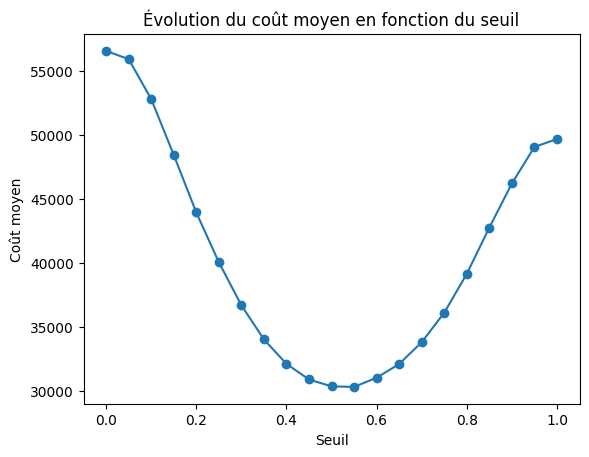

In [15]:
# Générer le graphique
plt.plot(thresholds, ls_cost, marker='o')
plt.xlabel('Seuil')
plt.ylabel('Coût moyen')
plt.title('Évolution du coût moyen en fonction du seuil')
plt.show()

In [16]:
# Afficher le meilleur seuil et son coût associé
print(f"Le meilleur seuil trouvé est : {best_threshold:.2f} avec un coût moyen de : {best_score:.2f}")

Le meilleur seuil trouvé est : 0.55 avec un coût moyen de : 30279.80


In [69]:
# Diviser les données en deux parties : train et validation
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Vérifier les formes des ensembles
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"y_train_final shape: {y_train_final.shape}")
print(f"y_val_final shape: {y_val_final.shape}")

X_train_final shape: (215257, 808)
X_val_final shape: (92254, 808)
y_train_final shape: (215257,)
y_val_final shape: (92254,)


In [70]:
# Entraîner le modèle final sur les données d'entraînement
final_model.fit(X_train_final, y_train_final)

# Afficher un message de confirmation
print("Le modèle final a été entraîné sur les données d'entraînement.")

Le modèle final a été entraîné sur les données d'entraînement.


In [71]:
# Prédire les probabilités sur l'ensemble de validation
y_probs_val = final_model.predict_proba(X_val_final)[:, 1]  # Probabilités pour la classe 1

# Appliquer le seuil optimisé pour obtenir les prédictions binaires
y_pred_val = (y_probs_val >= best_threshold).astype(int)

Cette fonction effectue une validation croisée pour évaluer le score métier du modèle en appliquant le seuil optimisé. Elle entraîne le modèle, applique le seuil pour obtenir des prédictions binaires, calcule le coût métier pour chaque pli, et retourne le score moyen.

In [72]:
# Calculer les métriques
business_score = -custom_cost_function(y_val_final, y_pred_val)
auc_val = roc_auc_score(y_val_final, y_probs_val)
f1_val = f1_score(y_val_final, y_pred_val)
precision_val = precision_score(y_val_final, y_pred_val, zero_division=1)
recall_val = recall_score(y_val_final, y_pred_val)

# Afficher les résultats
print(f"Business Score: {business_score}")
print(f"AUC: {auc_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")
print(f"Précision: {precision_val:.4f}")
print(f"Rappel: {recall_val:.4f}")

# Afficher la matrice de confusion
print("Matrice de confusion :")
print(confusion_matrix(y_val_final, y_pred_val))

Business Score: 45227
AUC: 0.7859
F1-Score: 0.3062
Précision: 0.1997
Rappel: 0.6553
Matrice de confusion :
[[65249 19557]
 [ 2567  4881]]


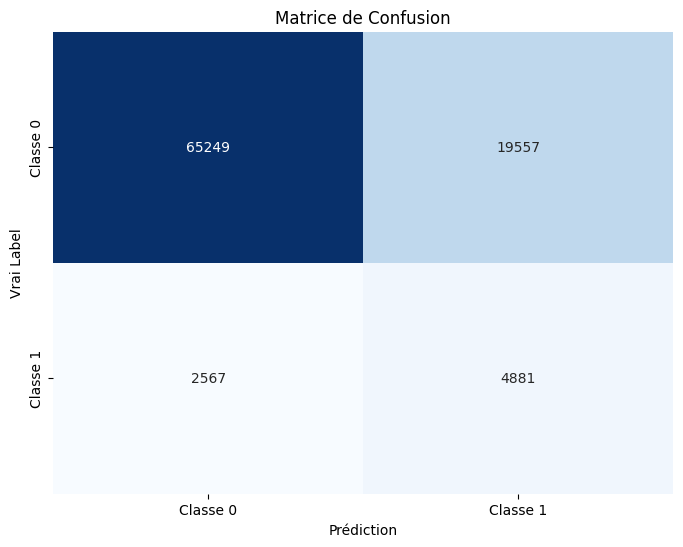

In [73]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_val_final, y_pred_val)

# Afficher la heatmap de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Prédiction')
plt.ylabel('Vrai Label')
plt.title('Matrice de Confusion')
plt.show()

Ce code extrait le modèle LightGBM du pipeline final, récupère et trie les importances des features, puis crée un graphique pour visualiser les 20 features les plus importantes en fonction de leur impact sur les prédictions du modèle.

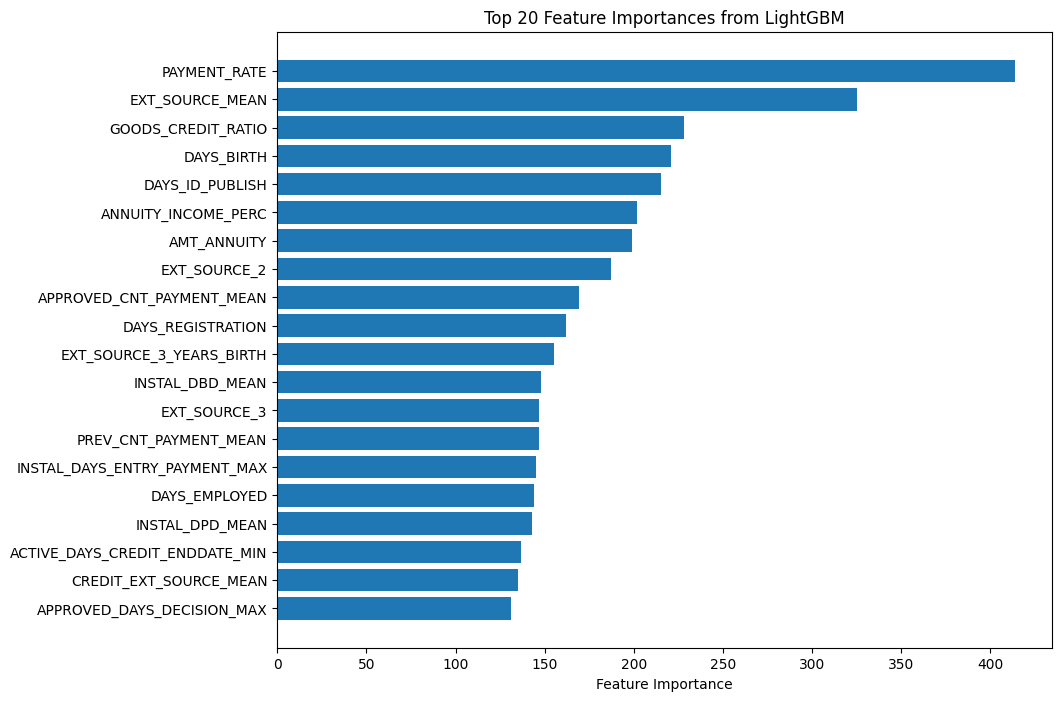

In [74]:
# Extraire le modèle LightGBM du pipeline
lgb_model = final_model.named_steps['model']

# Récupérer l'importance des features
importances = lgb_model.feature_importances_
feature_names = X_train_final.columns

# Trier les features par importance (ordre croissant)
sorted_idx = importances.argsort()

# Garder seulement les 20 premières features les plus importantes
top_n = 20
top_features = sorted_idx[-top_n:]

# Créer le graphique pour les 20 premières features
plt.figure(figsize=(10, 8))
plt.barh(range(top_n), importances[top_features], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in top_features])
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances from LightGBM')
plt.show()

# SHAP

## feature importance globale

Ce code utilise SHAP pour expliquer les prédictions du modèle LightGBM en filtrant un warning spécifique, calculant les valeurs SHAP pour le jeu de validation, et affichant un summary plot pour visualiser l'importance globale des features.

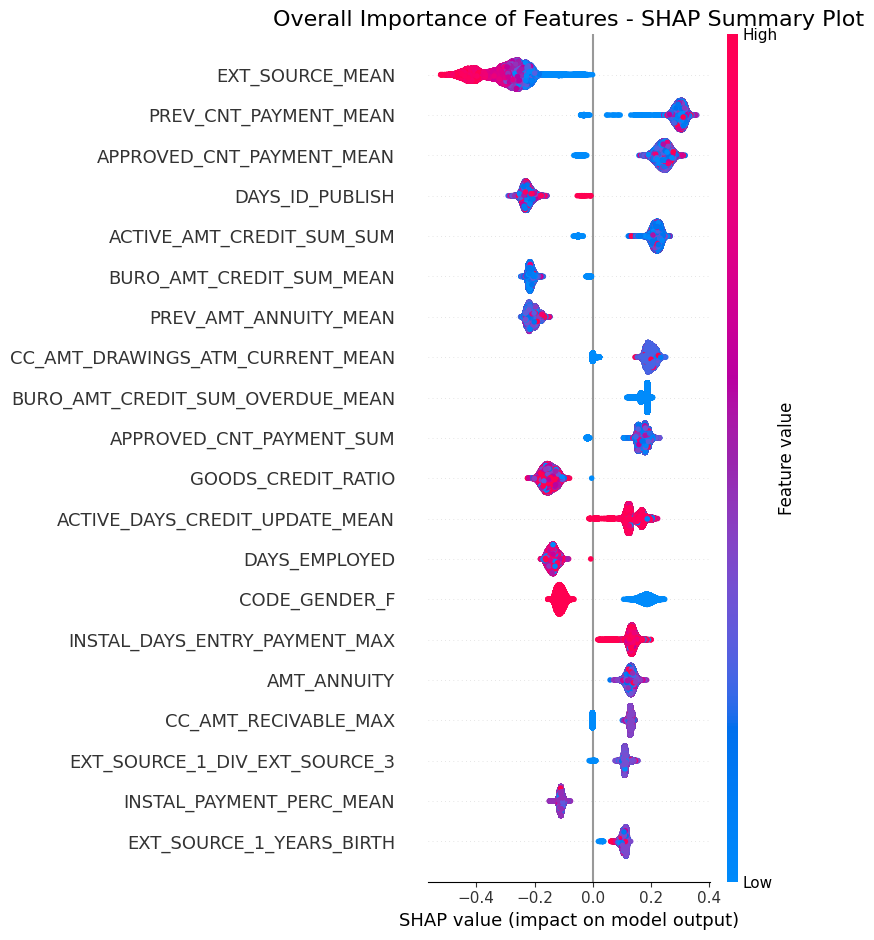

In [77]:
# Filtrer le warning spécifique de SHAP
warnings.filterwarnings("ignore", message=".*LightGBM binary classifier with TreeExplainer shap values output has changed.*")

# Créer un explainer SHAP basé sur ton modèle final
explainer = shap.TreeExplainer(lgb_model)

# Calculer les valeurs SHAP pour le jeu de validation
shap_values = explainer.shap_values(X_val_final)

# Si shap_values est une liste, prendre les valeurs pour la classe 1
shap_values_class_1 = shap_values[1] if isinstance(shap_values, list) else shap_values

# Vérifier les dimensions pour s'assurer que shap_values_class_1 est bien au format matriciel
assert len(shap_values_class_1.shape) == 2, "Les valeurs SHAP doivent être une matrice."

# Afficher le summary plot (importance globale des features)
plt.title("Overall Importance of Features - SHAP Summary Plot", fontsize=16)  # Titre pour le summary plot
shap.summary_plot(shap_values_class_1, X_val_final, feature_names=X_val_final.columns)

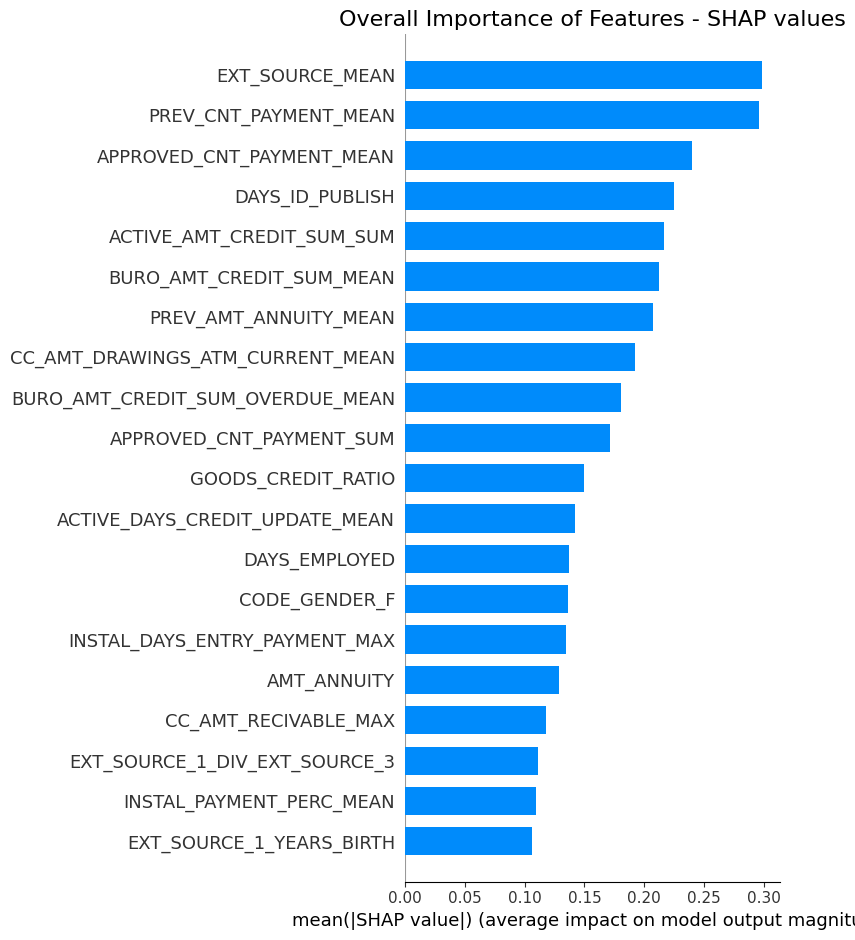

In [66]:
# Afficher le barplot de l'importance globale des features avec SHAP
plt.title("Overall Importance of Features - SHAP values", fontsize=16)
shap.summary_plot(shap_values_class_1, X_val_final, feature_names=X_val_final.columns, plot_type="bar")

Ce code calcule et visualise les valeurs SHAP pour expliquer la prédiction d'une instance spécifique du jeu de validation en affichant un force plot, ce qui montre l'impact de chaque feature sur la décision du modèle.

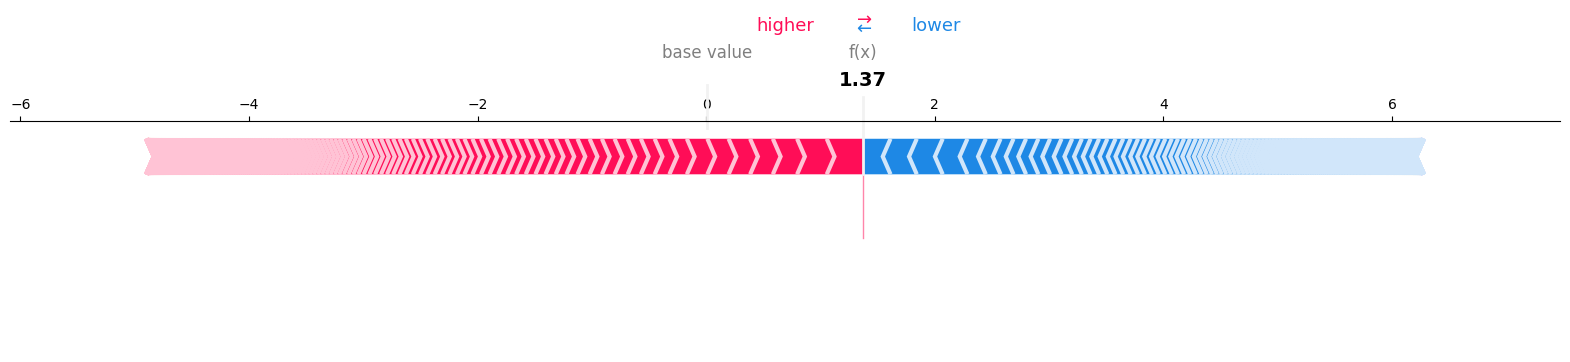

In [25]:
# Sélectionner une instance (ligne) du jeu de validation
instance_index = 0  # Par exemple, l'index 0 correspond à la première instance du jeu de validation
instance_to_explain = X_val_final.iloc[[instance_index]]

# Calculer les valeurs SHAP pour cette instance
shap_values_instance = explainer.shap_values(instance_to_explain)

# Si shap_values_instance est une liste (par exemple pour un modèle binaire), prendre les valeurs pour la classe 1
shap_values_instance_class_1 = shap_values_instance[1] if isinstance(shap_values_instance, list) else shap_values_instance

# Vérifier la dimension pour s'assurer que shap_values_instance_class_1 est bien une matrice
assert len(shap_values_instance_class_1.shape) == 2, "Les valeurs SHAP doivent être une matrice."

# Afficher un force plot statique pour expliquer la prédiction de cette instance
shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
                shap_values_instance_class_1[0, :], 
                instance_to_explain, 
                feature_names=X_val_final.columns, 
                matplotlib=True)

# Afficher le graphique
plt.show()

Ce code crée un objet SHAP Explanation pour une instance spécifique, puis génère et affiche un Waterfall Plot pour visualiser comment chaque feature contribue à la prédiction du modèle.

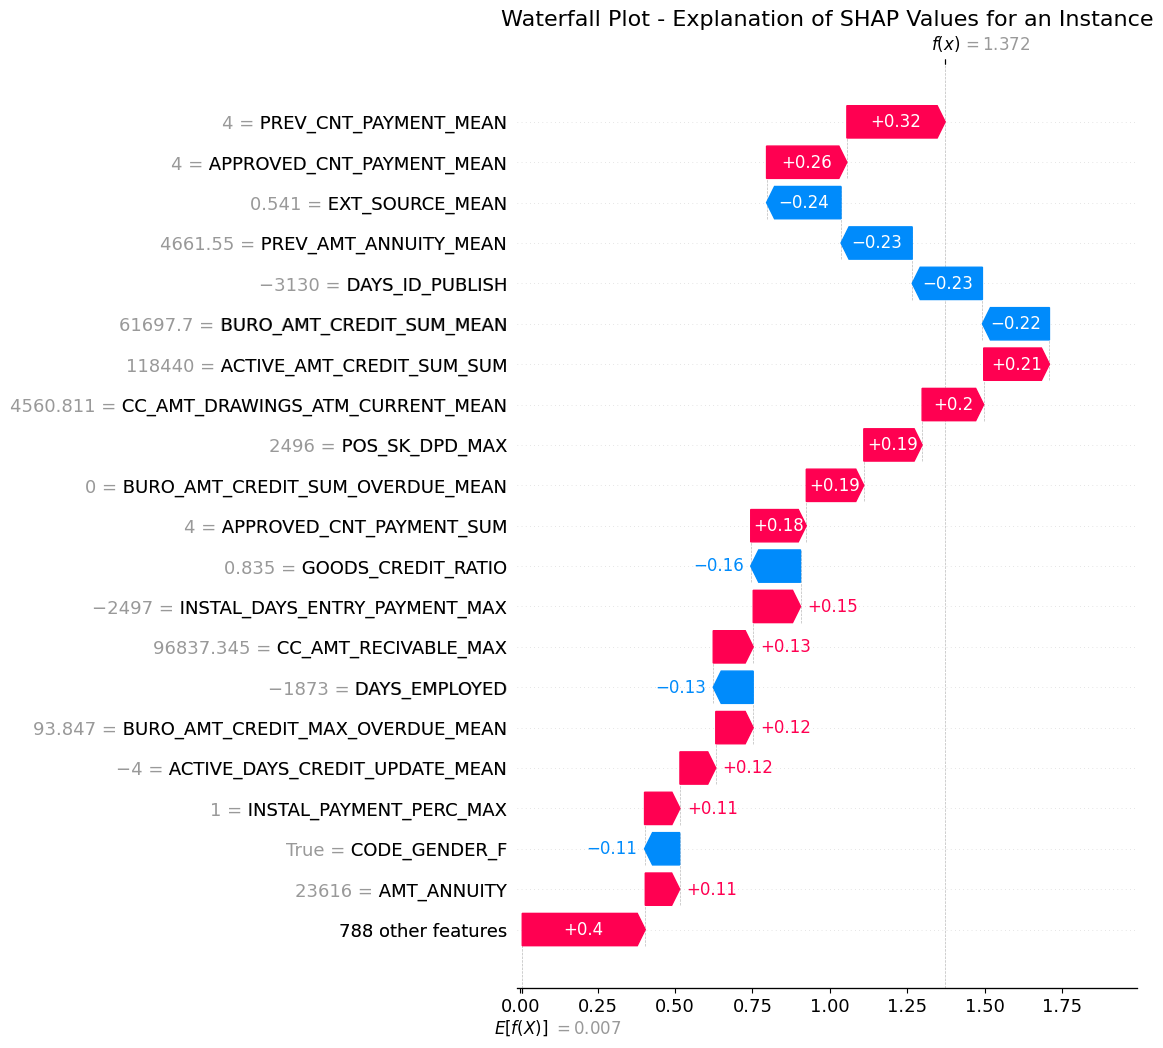

In [78]:
# Créer un objet Explanation pour le Waterfall Plot
shap_values_exp = shap.Explanation(
    values=shap_values_instance_class_1[0], 
    base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value, 
    data=instance_to_explain.iloc[0],  # Utiliser une seule ligne pour correspondre aux valeurs SHAP
    feature_names=X_val_final.columns
)

# Créer une nouvelle figure pour le graphique avec un titre
plt.figure(figsize=(10, 6))
plt.title("Waterfall Plot - Explanation of SHAP Values for an Instance", fontsize=16)

# Générer le Waterfall Plot pour la même instance
shap.plots.waterfall(shap_values_exp, max_display=21)

# Afficher le graphique
plt.show()

Ce code compare l'importance des features obtenue à partir de LightGBM et de SHAP, en calculant une importance moyenne pour chaque feature, puis trie et affiche ces importances dans un DataFrame récapitulatif.

In [27]:
# Obtenir l'importance des features depuis LightGBM
lgbm_importances = pd.Series(final_model.named_steps['model'].feature_importances_, index=X_train_final.columns)

# Obtenir l'importance des features depuis SHAP
# Calculer les valeurs SHAP globales
shap_values_global = explainer.shap_values(X_train_final)
shap_importances = pd.Series(np.abs(shap_values_global[1]).mean(axis=0), index=X_train_final.columns)

# Créer un DataFrame récapitulatif
importance_df = pd.DataFrame({
    'LightGBM Importance': lgbm_importances,
    'SHAP Importance': shap_importances
})

# Ajouter une colonne pour l'importance moyenne (moyenne des rangs)
importance_df['Average Rank'] = (importance_df['LightGBM Importance'].rank(ascending=False) + 
                                 importance_df['SHAP Importance'].rank(ascending=False)) / 2

# Trier le DataFrame par l'importance moyenne
importance_df = importance_df.sort_values('Average Rank', ascending=True)

# Afficher le DataFrame récapitulatif
importance_df

,LightGBM Importance,SHAP Importance,Average Rank
PAYMENT_RATE,414,0.012986,202.75
EXT_SOURCE_MEAN,325,0.012986,203.25
GOODS_CREDIT_RATIO,228,0.012986,203.75
DAYS_BIRTH,221,0.012986,204.25
DAYS_ID_PUBLISH,215,0.012986,204.75
...,...,...,...
CC_CNT_INSTALMENT_MATURE_CUM_MIN,0,0.012986,543.25
CC_SK_DPD_MIN,0,0.012986,543.25
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR,0,0.012986,543.25
CC_CNT_DRAWINGS_POS_CURRENT_MIN,0,0.012986,543.25


In [28]:
def retrain_and_evaluate_model_with_business_score(model, X_train, y_train, X_val, y_val, top_features, best_threshold):
    # Réduire les ensembles de données à `top_features`
    X_train_reduced = X_train[top_features]
    X_val_reduced = X_val[top_features]
    
    # Entraîner le modèle avec les meilleurs hyperparamètres
    model.fit(X_train_reduced, y_train)

    # Prédire sur l'ensemble de validation
    y_probs_val = model.predict_proba(X_val_reduced)[:, 1]
    y_pred_val = (y_probs_val >= best_threshold).astype(int)
    
    # Calculer les métriques
    business_score = -custom_cost_function(y_val, y_pred_val)
    auc_val = roc_auc_score(y_val, y_probs_val)
    f1_val = f1_score(y_val, y_pred_val)
    precision_val = precision_score(y_val, y_pred_val, zero_division=1)
    recall_val = recall_score(y_val, y_pred_val)
    
    # Retourner les résultats sous forme de dictionnaire
    return {
        'Business Score': business_score,
        'num_features': len(top_features),
        'AUC': auc_val,
        'F1-Score': f1_val,
        'Precision': precision_val,
        'Recall': recall_val,
    }

In [29]:
def compare_model_with_varied_features_and_business_score(model, importance_df, X_train, y_train, X_val, y_val, feature_sets, best_threshold):
    all_results = []
    
    for num_features in feature_sets:
        # Sélectionner les `num_features` plus importantes
        top_features = importance_df.index[:num_features]
        print(f"Testing with top {num_features} features")
        
        # Réentraîner et évaluer le modèle
        results = retrain_and_evaluate_model_with_business_score(model, X_train, y_train, X_val, y_val, top_features, best_threshold)
        
        # Ajouter les résultats à la liste
        all_results.append(results)
    
    # Convertir les résultats en DataFrame pour comparaison
    results_df = pd.DataFrame(all_results)
    return results_df

# Exécuter la comparaison avec les sets de features définis
feature_sets = [20, 50, 75, 100, 150, 200, 250, 300, 350, 400]
results_df = compare_model_with_varied_features_and_business_score(final_model, importance_df, X_train_final, y_train_final, X_val_final, y_val_final, feature_sets, best_threshold)

# Afficher les résultats
print(results_df)

Testing with top 20 features
Testing with top 50 features
Testing with top 75 features
Testing with top 100 features
Testing with top 150 features
Testing with top 200 features
Testing with top 250 features
Testing with top 300 features
Testing with top 350 features
Testing with top 400 features
   Business Score  num_features       AUC  F1-Score  Precision    Recall
0           49057            20  0.759514  0.280923   0.181441  0.621912
1           47536            50  0.772893  0.291552   0.189459  0.632250
2           46270            75  0.779201  0.298920   0.194368  0.646885
3           46385           100  0.779561  0.298773   0.194523  0.643797
4           46020           150  0.781606  0.301421   0.196538  0.646348
5           45997           200  0.782375  0.301556   0.196628  0.646617
6           45470           250  0.783554  0.305019   0.199114  0.651584
7           45333           300  0.784834  0.305351   0.199110  0.654672
8           45509           350  0.785008  0.3

Les résultats présentés ci-dessus montrent l'évolution des performances du modèle en fonction du nombre de features utilisées. On observe que l'AUC et le F1-Score augmentent progressivement avec le nombre de features, atteignant un plateau autour de 300 features. Au-delà de ce point, les améliorations deviennent marginales, voire inexistantes, ce qui indique que le modèle a déjà capturé l'essentiel des informations pertinentes. Par conséquent, 300 features semble être le meilleur compromis entre complexité et performance, offrant les meilleures performances globales sans ajouter de complexité inutile.